## 1. Challenge Dataset

In [10]:
rows_standard   = 200
cols_standard   = 200

### Utrecht and Singapore

In [116]:
singapore_path  = '/home/msc2/Documents/Data/WMH_Challenge/public/Singapore/Singapore/'
utrecht_path    = '/home/msc2/Documents/Data/WMH_Challenge/public/Utrecht/Utrecht/'

In [117]:
import nibabel as nib
import os
import scipy
import numpy as np
import cv2
from tqdm import tqdm

def utrecht_preprocess(folder_path, 
                       output_path='/home/msc2/DATA/Slices',
                       naming='challenge',
                       range_=(8,8),
                       valid_split=[]
                      ):
    # load the nii files
    full_flair_path = os.path.join(folder_path, "pre", "FLAIR_final.nii")
    full_mask_path  = os.path.join(folder_path, "wmh.nii")
    file_name       = folder_path.split('/')[-1]
    
    # rotate the axial slices such that the eyes face up
    flair = np.rot90(nib.load(full_flair_path).get_fdata(), k=3)
    mask  = np.rot90(nib.load(full_mask_path).get_fdata(),  k=3)
    
    # cropping to desired shape
    num_selected_slice = np.shape(flair)[2]
    rows   = np.shape(flair)[0]
    cols   = np.shape(flair)[1]
    
    flair  = flair[(rows//2 - rows_standard//2):(rows//2 + rows_standard//2), (cols//2 - cols_standard//2):(cols//2 + cols_standard//2), :]
    
    flair -= np.mean(flair)
    flair /=  np.std(flair)

    mask   =  mask[(rows//2 - rows_standard//2):(rows//2 + rows_standard//2), (cols//2 - cols_standard//2):(cols//2 + cols_standard//2), :]

    flair  = flair[..., np.newaxis]
    mask   =  mask[..., np.newaxis]
    
    if len(np.unique(mask)) > 2:
        mask[mask == 2] = 0

    if file_name in valid_split:
        output_path = os.path.join(output_path, 'valid')
    else:
        output_path = os.path.join(output_path, 'train')
        
    # create directory for output
    if not os.path.exists(output_path):
        os.mkdir(output_path)
        
    flair_img = ((flair - flair.min())/(flair.max() - flair.min()) * 255).astype(np.uint8)
    mask_img  = (mask * 255).astype(np.uint8)
    
    # output as npy slices in output folder
    start, end = range_
    for i in range(start, flair.shape[2] - end):
        out_file_path = os.path.join(output_path, f"{naming}_{file_name.zfill(3)}_IMG00{str(i).zfill(2)}")
        if mask[:,:,i].sum() > 50:
            cv2.imwrite(f'{out_file_path}_flair.png', flair_img[:,:,i])
            cv2.imwrite(f'{out_file_path}_mask.png',   mask_img[:,:,i])

In [118]:
import random
random.seed(48)

cases = [case.split('_')[-1] for case in os.listdir(singapore_path)]
num_samples = round(0.2 * len(cases))
samples = random.sample(cases, num_samples)
print(samples)

['58', '54', '63', '57']


In [119]:
for case in tqdm(os.listdir(singapore_path), 'Cases : '):
    folder_path = os.path.join(singapore_path, case)
    utrecht_preprocess(folder_path, naming='sing', valid_split=samples)

Cases : 100%|███████████████████████████████████| 20/20 [00:03<00:00,  6.17it/s]


### Amsterdam

In [97]:
amsterdam_path = '/home/msc2/Documents/Data/WMH_Challenge/public/Amsterdam_GE3T/GE3T/'

In [113]:
def GE3T_preprocess(folder_path, 
                    output_path='/home/msc2/DATA/Slices', 
                    naming='amst',
                    range_=(6,6),
                    valid_split=[]
                   ):
    # load the nii files
    start_cut = 46
    full_flair_path = os.path.join(folder_path, "pre", "FLAIR_final.nii")
    full_mask_path  = os.path.join(folder_path, "wmh.nii")
    file_name       = folder_path.split('/')[-1]
    
    # rotate the axial slices such that the eyes face up
    flair = np.float32(np.rot90(nib.load(full_flair_path).get_fdata(), k=3))
    mask  = np.rot90(nib.load(full_mask_path).get_fdata(),             k=3)
    
    if len(np.unique(mask)) > 2:
        mask[mask == 2] = 0
    
    # cropping to desired shape
    num_selected_slice = np.shape(flair)[2]
    rows = np.shape(flair)[0]
    cols = np.shape(flair)[1]

    flair_suitable = np.ndarray((rows_standard, cols_standard, num_selected_slice), dtype=np.float32)
    mask_suitable  =   np.zeros((rows_standard, cols_standard, num_selected_slice), dtype=np.float32)

    flair -= np.mean(flair)
    flair /=  np.std(flair)
    
    flair_suitable[...] = np.min(flair)
    flair_suitable[:, (cols_standard//2 - cols//2):(cols_standard//2 + cols//2), :] = flair[start_cut:start_cut + rows_standard, :, :]
    mask_suitable[:, (cols_standard//2 - cols//2):(cols_standard//2 + cols//2), :] =  mask[start_cut:start_cut + rows_standard, :, :]
    mask_suitable   =  mask_suitable[..., np.newaxis]
    flair_suitable  = flair_suitable[..., np.newaxis]
    
    if file_name in valid_split:
        output_path = os.path.join(output_path, 'valid')
    else:
        output_path = os.path.join(output_path, 'train')
        
    # create directory for output
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    
    flair_img = ((flair_suitable - flair_suitable.min())/(flair_suitable.max() - flair_suitable.min()) * 255).astype(np.uint8)
    mask_img  = (mask_suitable * 255).astype(np.uint8)
    
    # output as npy slices in output folder
    start, end = range_
    for i in range(start, flair.shape[2] - end):
        out_file_path = os.path.join(output_path, f"{naming}_{file_name.zfill(3)}_IMG00{str(i).zfill(2)}")
        if mask[:,:,i].sum() > 50:
            cv2.imwrite(f'{out_file_path}_flair.png', flair_img[:,:,i])
            cv2.imwrite(f'{out_file_path}_mask.png',   mask_img[:,:,i])

In [114]:
import random
random.seed(48)

cases = [case.split('_')[-1] for case in os.listdir(amsterdam_path)]
num_samples = round(0.2 * len(cases))
samples = random.sample(cases, num_samples)
print(samples)

['137', '126', '107', '108']


In [115]:
for case in tqdm(os.listdir(amsterdam_path), 'Cases : '):
    folder_path = os.path.join(amsterdam_path, case)
    GE3T_preprocess(folder_path, naming='amst', range_=(35,25), valid_split=samples)

Cases : 100%|███████████████████████████████████| 20/20 [00:04<00:00,  4.90it/s]


## 2. SSSIHMS Dataset

In [120]:
sssihms_path = '/home/msc2/Documents/Data/WMH-SSSIHMS/'

In [121]:
import nibabel as nib
import os
import numpy as np
from tqdm import tqdm
import random
import albumentations as A

def sssihms_preprocess(folder_path, 
                       output_path='/home/msc2/DATA/Slices', 
                       naming='ihms',
                       range_=(5,5),
                       valid_split=[]
                      ):
    # load the nii files
    full_flair_path = os.path.join(folder_path, "pre", "FLAIR_final.nii")
    full_mask_path  = os.path.join(folder_path, "wmh.nii")
    file_name       = folder_path.split('_')[-1]
    
    resize = A.Resize(220,200)
    
    # rotate the axial slices such that the eyes face up
    flair = np.rot90(nib.load(full_flair_path).get_fdata(), k=1)
    mask  = np.rot90(nib.load(full_mask_path).get_fdata(),  k=1)
        
    flair =          resize(image=flair)['image']
    mask  = np.round(resize(image= mask)['image'])
        
    # cropping to desired shape
    num_selected_slice = np.shape(flair)[2]
    rows = 220
    cols = 200

    flair            =            flair[(rows//2 - rows_standard//2):(rows//2 + rows_standard//2), (cols//2 - cols_standard//2):(cols//2 + cols_standard//2), :]
    
    flair -= np.mean(flair)
    flair /=  np.std(flair)

    mask   =  mask[(rows//2 - rows_standard//2):(rows//2 + rows_standard//2), (cols//2 - cols_standard//2):(cols//2 + cols_standard//2), :]
    
    flair  = flair[..., np.newaxis]
    mask   =  mask[..., np.newaxis]
    
    if file_name in valid_split:
        output_path = os.path.join(output_path, 'valid')
    else:
        output_path = os.path.join(output_path, 'train')
        
    # create directory for output
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    
    
    # output as npy slices in output folder
    flair_img = ((flair - flair.min())/(flair.max() - flair.min()) * 255).astype(np.uint8)
    mask_img  = (mask * 255).astype(np.uint8)
    
    # output as npy slices in output folder
    start, end = range_
    for i in range(start, flair.shape[2] - end):
        out_file_path = os.path.join(output_path, f"{naming}_{file_name.zfill(3)}_IMG00{str(i).zfill(2)}")
        if mask[:,:,i].sum() > 50:
            cv2.imwrite(f'{out_file_path}_flair.png', flair_img[:,:,i])
            cv2.imwrite(f'{out_file_path}_mask.png',   mask_img[:,:,i])

In [122]:
import random
random.seed(48)

cases = [case.split('_')[-1] for case in os.listdir(sssihms_path)]
num_samples = round(0.2 * len(cases))
samples = random.sample(cases, num_samples)
print(samples)

['24', '63', '78', '26', '18', '79', '25', '31', '70', '27', '77', '46', '20', '47', '64']


In [123]:
for case in tqdm(os.listdir(sssihms_path), 'Cases : '):
    folder_path = os.path.join(sssihms_path, case)
    sssihms_preprocess(folder_path, range_=(10,7), valid_split=samples)

Cases : 100%|███████████████████████████████████| 74/74 [00:04<00:00, 16.56it/s]


## 3. Chinese Dataset

In [124]:
import os

def rename_files(path):
    # Iterate over all files and directories in the given path
    for filename in os.listdir(path):
        # Construct the full path of the current item
        full_path = os.path.join(path, filename)
        # If the item is a file or directory with spaces in the name, rename it
        if '(' in filename:
            new_filename  = filename.translate(str.maketrans('()', '__'))
            new_full_path = os.path.join(path, new_filename)
            os.rename(full_path, new_full_path)
            full_path     = new_full_path  # Update full path with new name
            
        elif 'onlyWMH' in filename:
            new_filename = 'wmh.nii.gz'
            new_full_path = os.path.join(path, new_filename)
            os.rename(full_path, new_full_path)
            full_path = new_full_path  # Update full path with new name
            
        elif 't1' in filename:
            new_filename = 'T1_final.nii.gz'
            new_full_path = os.path.join(path, new_filename)
            os.rename(full_path, new_full_path)
            full_path = new_full_path  # Update full path with new name
        
        elif 'flair' in filename:
            new_filename = 'FLAIR_final.nii.gz'
            new_full_path = os.path.join(path, new_filename)
            os.rename(full_path, new_full_path)
            full_path = new_full_path  # Update full path with new name
        
        # If the item is a directory, recurse into it
        if os.path.isdir(full_path):
            rename_files(full_path)

In [125]:
# Call the replace_spaces function with the root directory
root_dir = '/home/msc2/Documents/Data/WMH_Chinese/'
rename_files(root_dir)

(396, 456, 17)


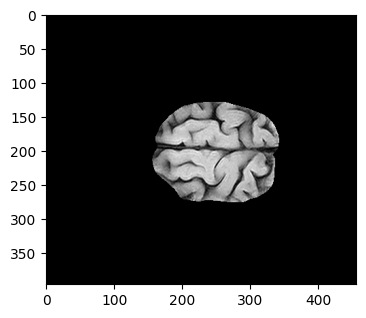

In [126]:
import nibabel as nib
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

image = nib.load('/home/msc2/Documents/Data/WMH_Chinese/WMH_10_/118091011733/FLAIR_final.nii.gz').get_fdata()
print(image.shape)

fig = plt.figure(figsize=(4,4))
ims = [[plt.imshow(image[:,:,i], cmap='gray', alpha=1, animated=True)] for i in range(image.shape[2])]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [127]:
input_dirs  = [root for root,_,_ in os.walk(root_dir)]
input_files = []
for in_dir in input_dirs:
    input_files.append([os.path.join(in_dir, file) for file in os.listdir(in_dir) if 'FLAIR' in file])
input_files = [file for sublist in input_files for file in sublist]
len(input_files)

94

In [128]:
import nibabel as nib
size = set()
for file in input_files:
    img = nib.load(file).get_fdata()
    size.add(img.shape)
size

{(396, 456, 17), (512, 512, 16), (512, 512, 17), (512, 512, 18)}

In [129]:
import random
random.seed(48)

cases = [str(i) for i in range(1,95)]
num_samples = round(0.2 * len(cases))
samples = random.sample(cases, num_samples)
print(samples)

['71', '41', '17', '72', '92', '69', '39', '65', '25', '56', '22', '20', '85', '14', '64', '84', '29', '28', '66']


In [130]:
import nibabel as nib
import os
import numpy as np
from tqdm import tqdm
import albumentations as A

def vbnet_preprocess(folder_path_, 
                     count='1',
                       output_path='/home/msc2/DATA/Slices', 
                       naming='vbnt',
                       range_=(2,2),
                       valid_split=[]
                      ):
    # load the nii files
    folder_path     = folder_path_.split('FLAIR')[0]
    full_flair_path = os.path.join(folder_path, "FLAIR_final.nii.gz")
    full_mask_path  = os.path.join(folder_path, "wmh.nii.gz")
    file_name = count
    
    resize = A.Resize(260,260)
    
    # rotate the axial slices such that the eyes face up
    flair  = np.rot90(nib.load(full_flair_path).get_fdata(), k=3)
    mask   = np.rot90(nib.load(full_mask_path).get_fdata(),  k=3)

    flair  =          resize(image=flair)['image']
    mask   = np.round(resize(image= mask)['image'])
        
    # cropping to desired shape
    num_selected_slice = np.shape(flair)[2]
    rows   = 260
    cols   = 260
    flair  = flair[(rows//2 - rows_standard//2):(rows//2 + rows_standard//2), (cols//2 - cols_standard//2):(cols//2 + cols_standard//2), :]
    mask   =  mask[(rows//2 - rows_standard//2):(rows//2 + rows_standard//2), (cols//2 - cols_standard//2):(cols//2 + cols_standard//2), :]
    
    # normalize the flair
    flair -= np.mean(flair)
    flair /=  np.std(flair)
    
    flair  = flair[..., np.newaxis]
    mask   =  mask[..., np.newaxis]
    
    if file_name in valid_split:
        output_path = os.path.join(output_path, 'valid')
    else:
        output_path = os.path.join(output_path, 'train')
        
    # create directory for output
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    
    # output as npy slices in output folder
    flair_img = ((flair - flair.min())/(flair.max() - flair.min()) * 255).astype(np.uint8)
    mask_img  = (mask * 255).astype(np.uint8)
    
    # output as npy slices in output folder
    start, end = range_
    for i in range(start, flair.shape[2] - end):
        out_file_path = os.path.join(output_path, f"{naming}_{file_name.zfill(3)}_IMG00{str(i).zfill(2)}")
        if mask[:,:,i].sum() > 50:
            cv2.imwrite(f'{out_file_path}_flair.png', flair_img[:,:,i])
            cv2.imwrite(f'{out_file_path}_mask.png',   mask_img[:,:,i])

In [131]:
count = 1
for case in tqdm(input_files, 'Cases : '):
    vbnet_preprocess(case, count=str(count), naming='vbnt', valid_split=samples)
    count += 1

Cases : 100%|███████████████████████████████████| 94/94 [00:12<00:00,  7.50it/s]


[0. 1.]


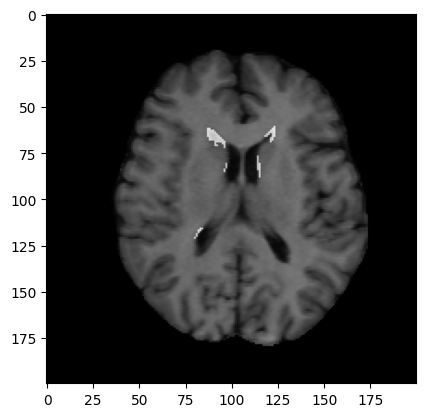

In [203]:
image = np.load('/home/msc2/DATA/Slices/train/vbnt_010_IMG0009_t1.npy')
mask  = np.load('/home/msc2/DATA/Slices/train/vbnt_010_IMG0009_mask.npy')
print(np.unique(mask))

import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='gray', alpha=0.5)

## The END